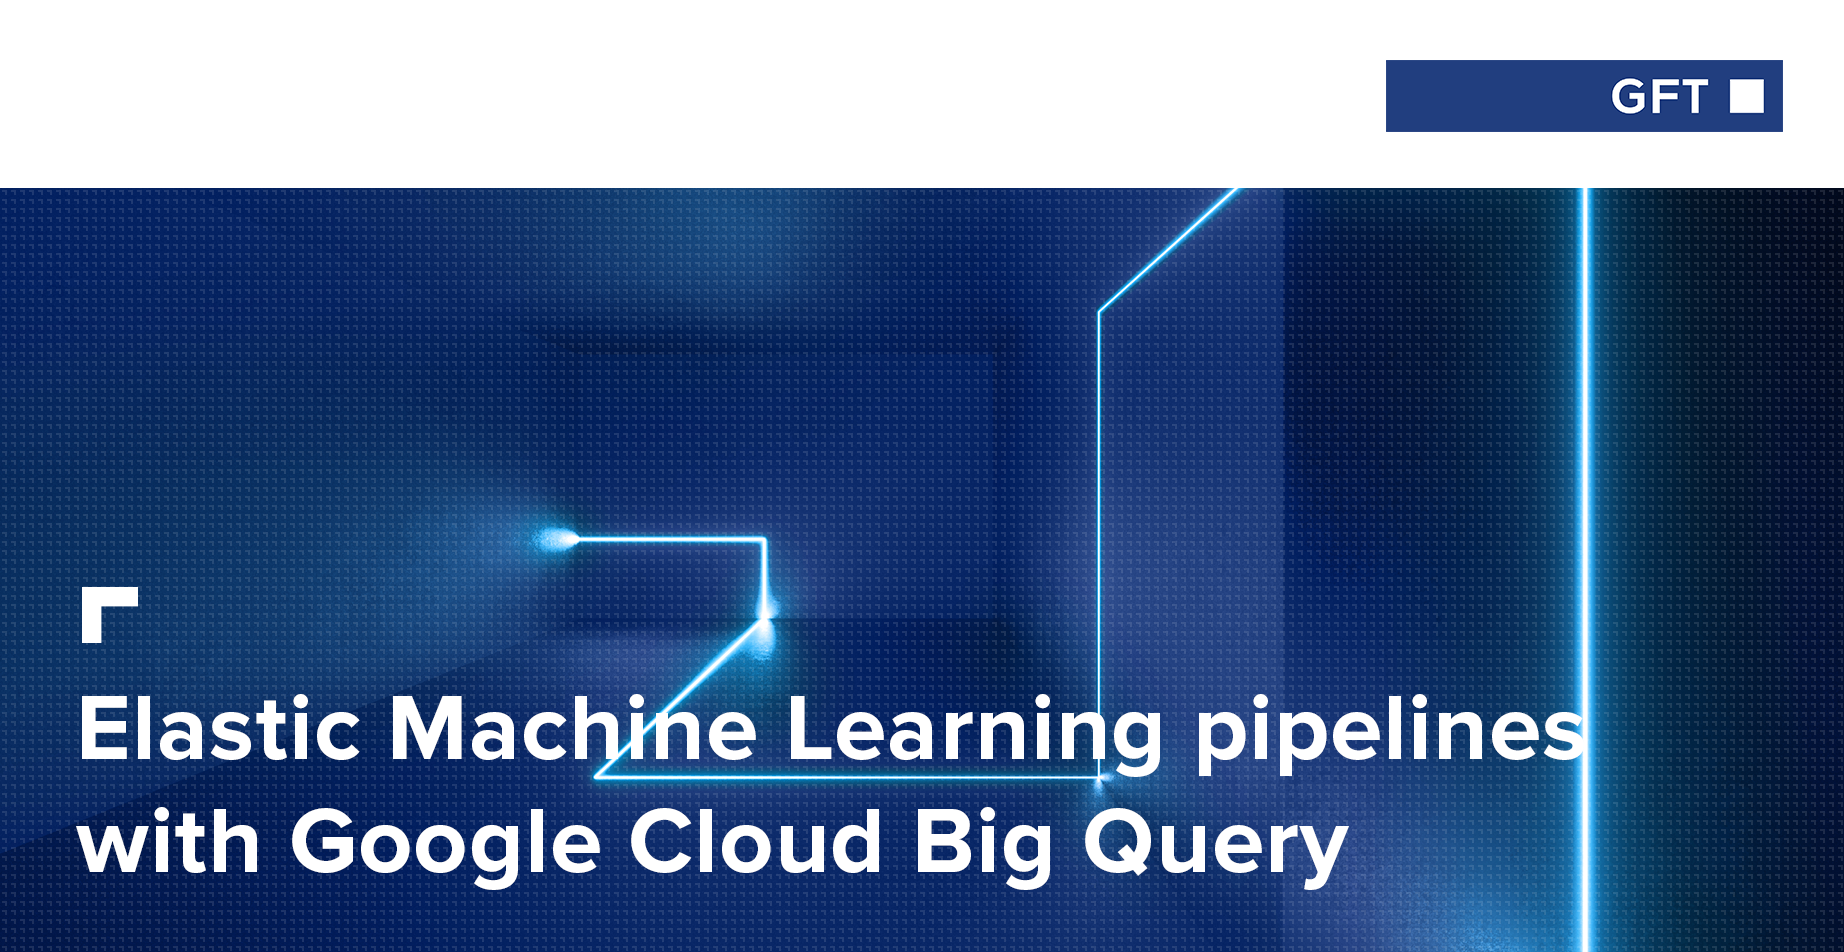

# 
# 
# 
# BigQuery w notatniku Jupyter

In [ ]:
%load_ext google.cloud.bigquery
%load_ext autotime

In [24]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="service_account.json"

from google.cloud import bigquery
client = bigquery.Client()

time: 12.1 ms


# Co to jest BigQuery?

* Hurtownia danych w chmurze Google
* Zapytania na olbrzymich danych trawają relatywnie krótko
* "Warm-up" nawet dla najprostszych zapytań
* Brak obsługi transakcji
* Brak INSERT'ów
* Dremel
* 100% as a service
* Płacisz tylko wtedy, kiedy używasz

# Kolumny vs Wiersze
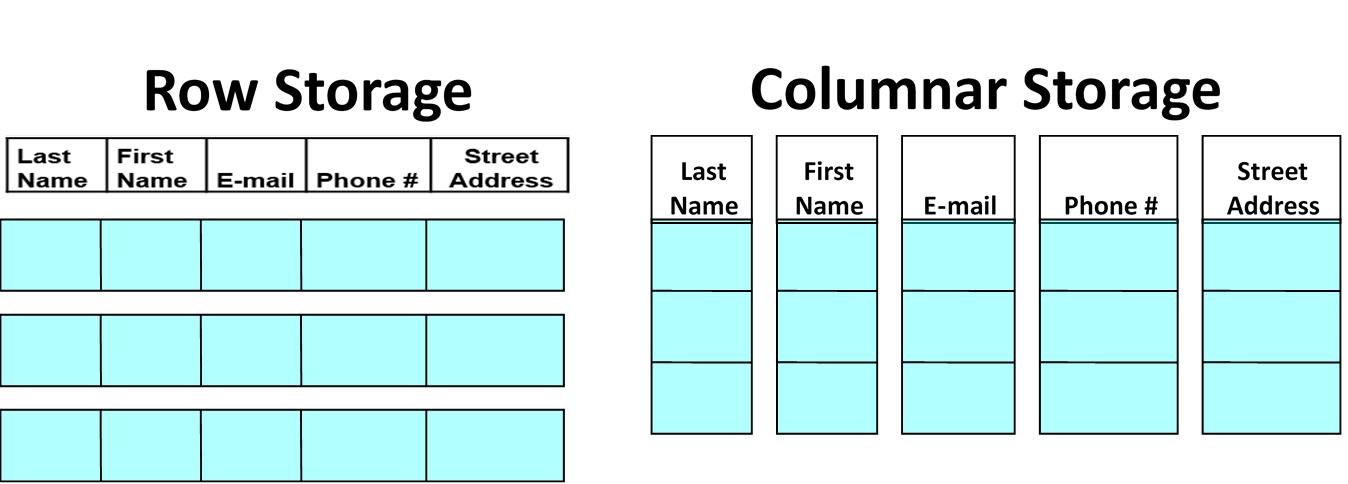

# Jakie zapytania są super szybkie?

In [25]:
%%bigquery
select max(transactionid) from ieee_cis_fraud_detection.train

,f0_
0,3577539


time: 1.51 s


# BigQuery w ekosystemie Google Cloud
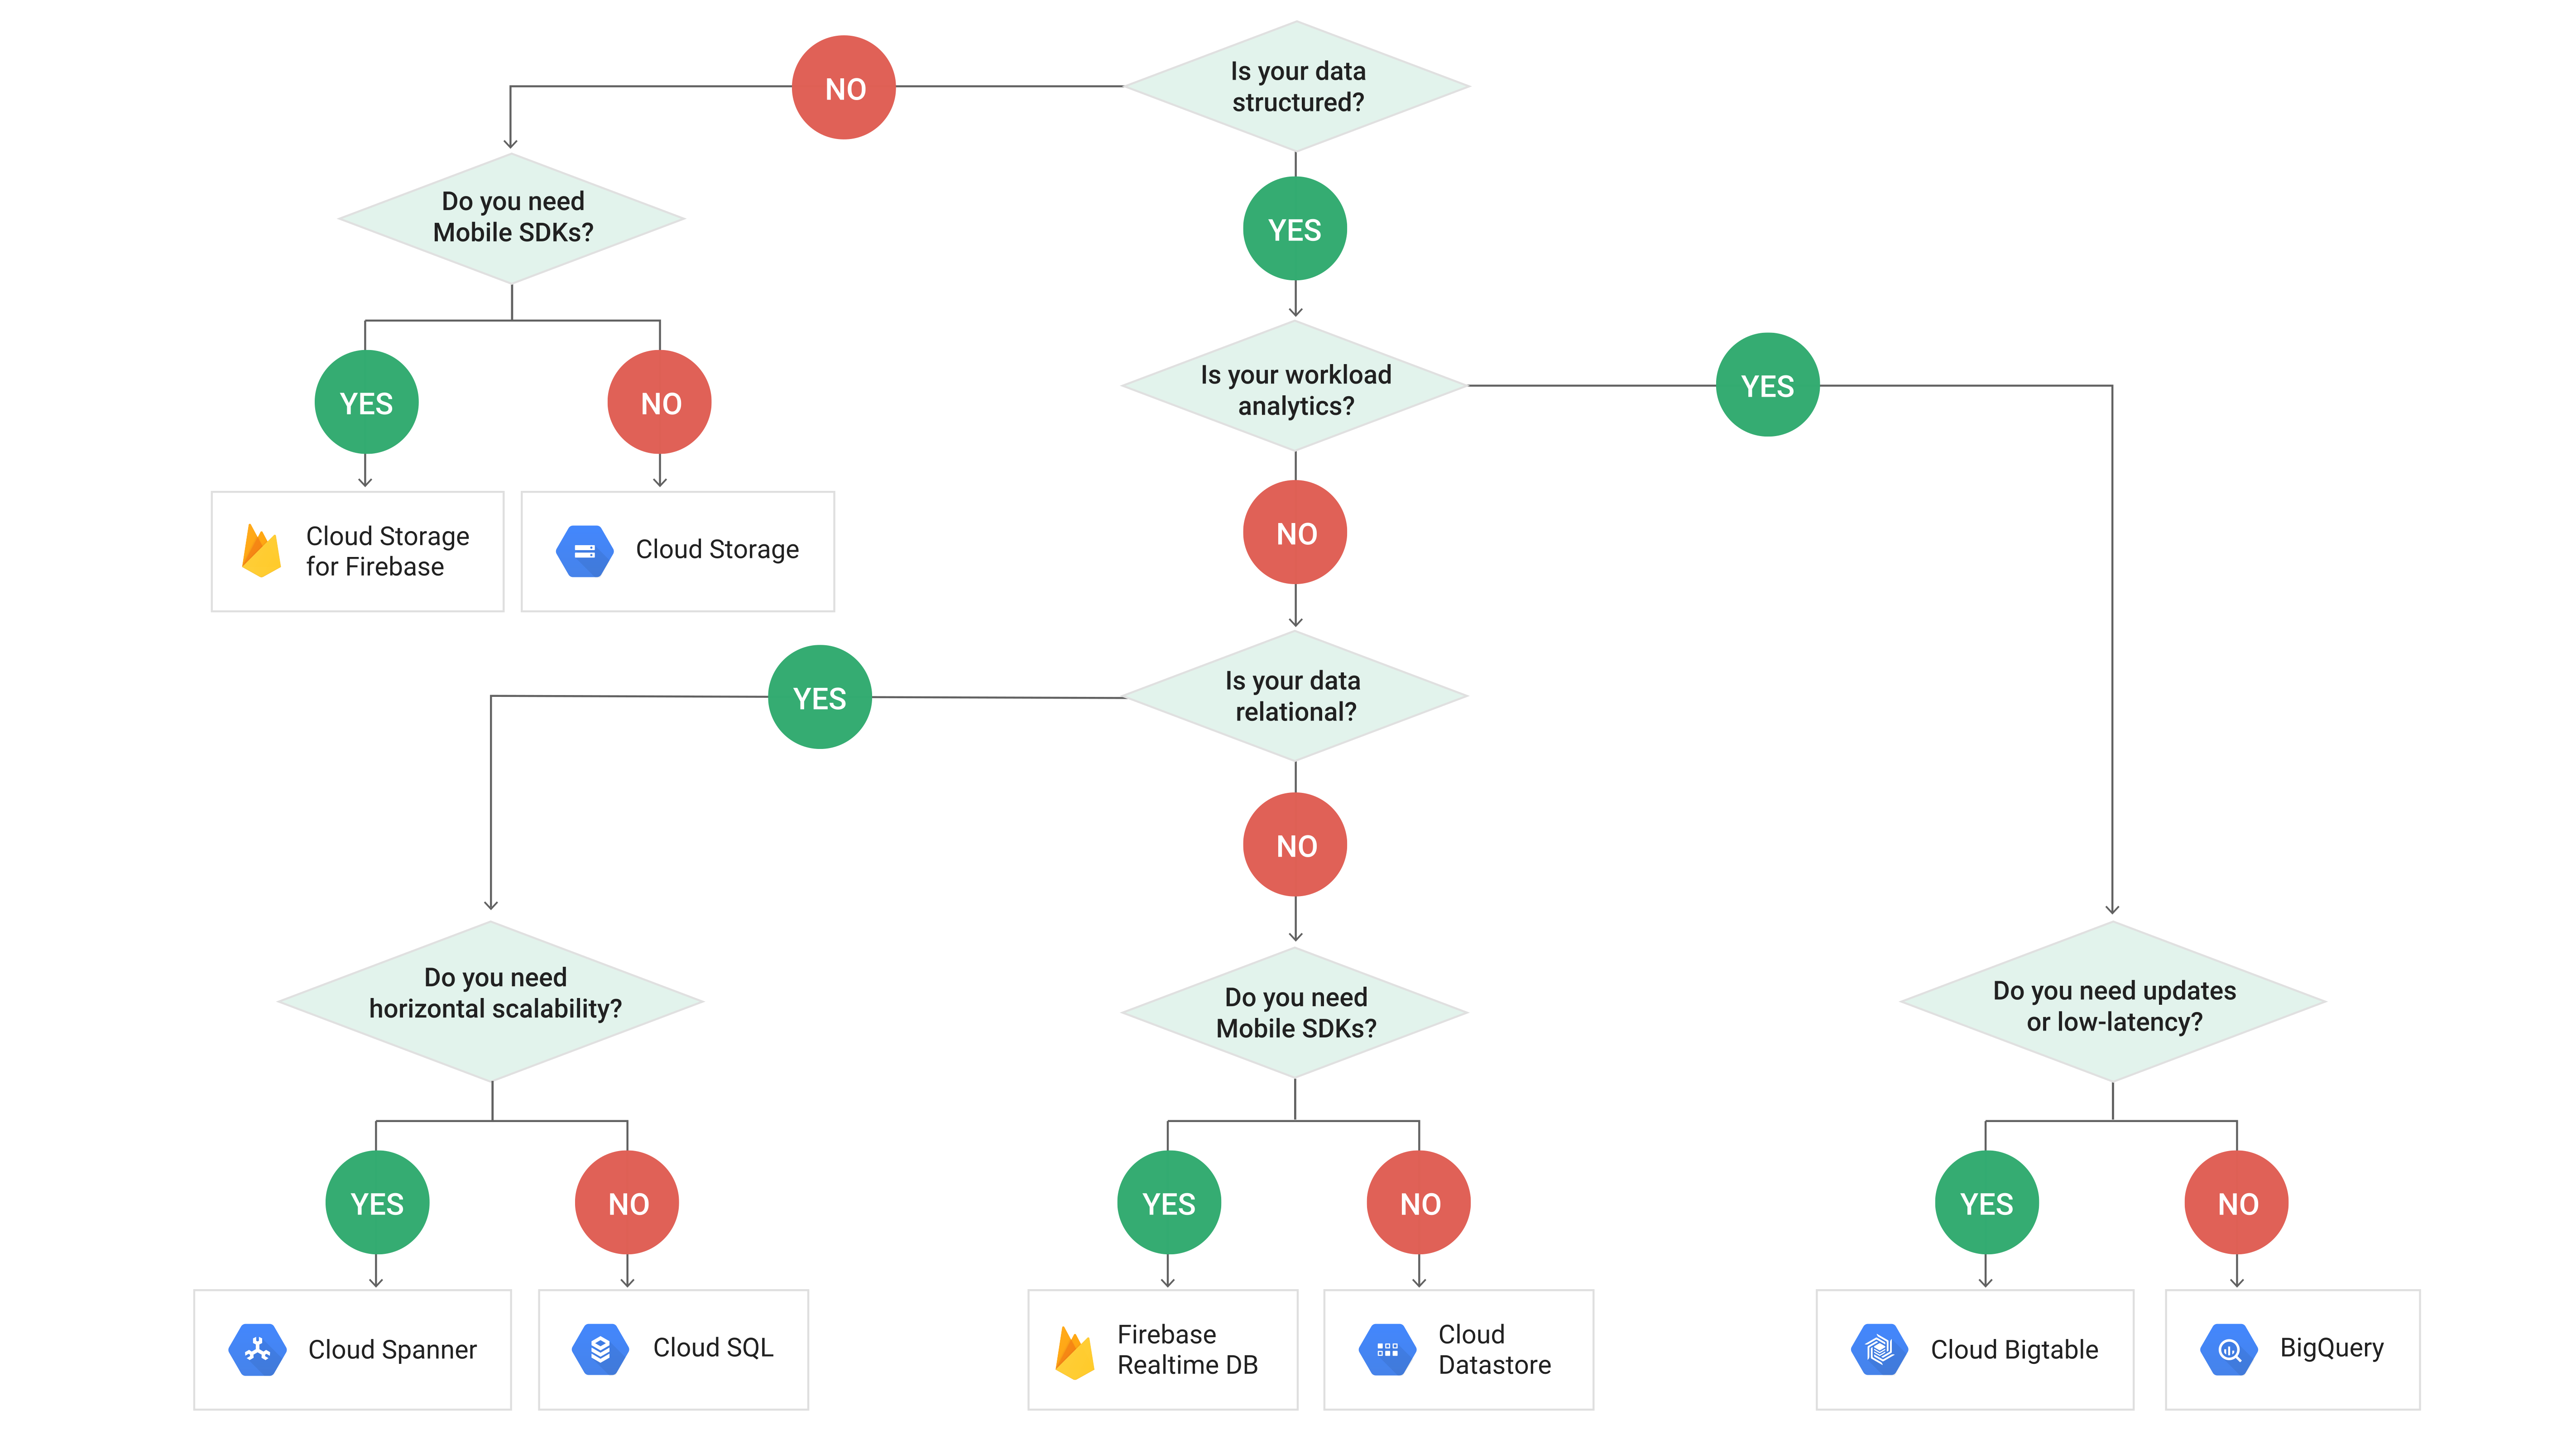

# Warm-up?

In [27]:
%%bigquery
SELECT * FROM ieee_cis_fraud_detection.train LIMIT 1;

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3523167,0,14136845,125.0,R,17188,321.0,150.0,visa,226.0,...,None,None,None,None,None,None,None,None,None,None


time: 1.43 s


# Oryginalny notes
https://www.kaggle.com/artgor/eda-and-models

# Jeśli przeczytasz tylko jedną rzecz o BigQuery, niech będzie to:
https://medium.com/velotio-perspectives/bigquery-101-all-the-basics-you-need-to-know-f298ac20268


# Wartość BigQuery w procesach Data Science

### Zasoby w procesie Data Science
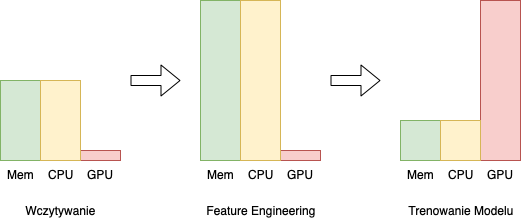

### Zasoby w procesie Jupyter
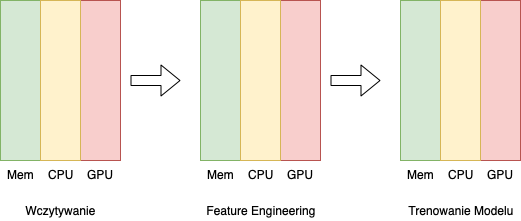

# Plan analizy

* Wstępna budowa zbioru treningowego
* Feature engineering
* Czyszczenie
* Trenowanie
* Analiza wyników

## Modyfikacje danych w BigQuery

In [13]:
%%bigquery
CREATE TABLE ieee_cis_fraud_detection.train as (
  select t.TransactionID, * except(TransactionID) from
  ieee_cis_fraud_detection.train_transaction t
  left join ieee_cis_fraud_detection.train_identity i
  on t.TransactionID = i.TransactionID
)

""


time: 30.2 s


## Funkcje używane w notatniku

In [21]:
def cfun(l):
    import numpy as np
    out = []
    ids = ", ".join([str(ex.features.feature['TransactionID'].int64_list.value[0]) for ex in l])
    ret = client.query("SELECT predicted_isFraud_probs FROM ML.PREDICT(MODEL ieee_cis_fraud_detection.fraud_detection, (SELECT * EXCEPT(TransactionID) FROM ieee_cis_fraud_detection.train_enriched_cleaned_up WHERE TransactionID IN ("+ids+")))").to_dataframe()
    for r in ret.iterrows():
        row = r[1]['predicted_isFraud_probs']
        if int(row[0]['label']) == 1:
            out.append([row[1]['prob'], row[0]['prob']])
        else:
            out.append([row[0]['prob'], row[1]['prob']]) 
    return np.asarray(out)

def df_to_examples(df, columns=None):
    import tensorflow as tf
    import numpy as np
    examples = []
    if columns == None:
        columns = df.columns.values.tolist()
    for index, row in df.iterrows():
        example = tf.train.Example()
        for col in columns:
            if df[col].dtype is np.dtype(np.int64) or df[col].dtype is np.dtype(np.int32):
                example.features.feature[col].int64_list.value.append(int(row[col]))
            elif df[col].dtype is np.dtype(np.float64):
                example.features.feature[col].float_list.value.append(row[col])
            elif row[col] == row[col]:
                example.features.feature[col].bytes_list.value.append(str(row[col]).encode('utf-8') if row[col] is not None else b'')
        examples.append(example)
    return examples

def get_all_cols_of(tbl):
    df = client.query("SELECT column_name FROM ieee_cis_fraud_detection.INFORMATION_SCHEMA.COLUMNS WHERE table_name = '{}'".format(tbl)).to_dataframe()
    return df['column_name'].to_list()
    #return [c for c in ret if c != 'isFraud']
    
def drop_cols(tbl, cols):
    cols = ", ".join(cols)
    return client.query("CREATE OR REPLACE TABLE {}_cleaned_up AS SELECT * EXCEPT ({}) FROM {}".format(tbl, cols, tbl)).result()    

def q_get_cnt_unique_one(tbl, col):
    q = "SELECT '{}', COUNT(DISTINCT {}) FROM ieee_cis_fraud_detection.{} where {} IS NOT NULL"
    return q.format(col, col, tbl, col)

def q_get_null_ratio_one(tbl, col):
    q = "SELECT '{}', (count({}) / count(1)) from ieee_cis_fraud_detection.{}"
    return q.format(col, col, tbl)

def q_get_top_value_freq_one(tbl, col):
    q = """
    SELECT '{}' as c, f from (
      (SELECT count(1) / (SELECT count(1) FROM ieee_cis_fraud_detection.{} WHERE {} IS NOT NULL) as f
      FROM ieee_cis_fraud_detection.{} WHERE {} IS NOT NULL
      GROUP BY {} order by f desc LIMIT 1)
    )"""
    return q.format(col, tbl, col, tbl, col, col)
    
def get_cnt_unique(tbl, col) -> int:
    print(f"get_cnt_unique: {tbl}.{col}")
    df = client.query(q_get_cnt_unique_one(tbl, col)).to_dataframe()
    return df.iloc[0][0]

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def q_get_unique(tbl, chunk_size):
    out = []
    for chunk in chunks(get_all_cols_of(tbl), chunk_size):
        out.append((chunk, " UNION ALL ".join([q_get_cnt_unique_one(tbl, col) for col in chunk])))
    return out

def q_get_null_ratio(tbl, chunk_size):
    out = []
    for chunk in chunks(get_all_cols_of(tbl), chunk_size):
        out.append((chunk, " UNION ALL ".join([q_get_null_ratio_one(tbl, col) for col in chunk])))
    return out

def q_get_top_value_freq(tbl, chunk_size):
    out = []
    for chunk in chunks(get_all_cols_of(tbl), chunk_size):
        out.append((chunk, "SELECT c, f FROM (" + " UNION ALL ".join([q_get_top_value_freq_one(tbl, col) for col in chunk]) + ")"))
    return out

def get_unique(tbl):
    out = None
    for chunk in q_get_unique(tbl, 50):
        cols = chunk[0]
        query = chunk[1]
        df = client.query(query).to_dataframe()
        df.columns = ['col', 'val']
        if out is None:
            out = df
        else:
            out = out.append(df)
    return out

def get_null_ratio(tbl):
    out = None
    for chunk in q_get_null_ratio(tbl, 50):
        cols = chunk[0]
        query = chunk[1]
        df = client.query(query).to_dataframe()
        df.columns = ['col', 'val']
        if out is None:
            out = df
        else:
            out = out.append(df)
    return out

def get_top_value_freq(tbl):
    out = None
    for chunk in q_get_top_value_freq(tbl, 40):
        cols = chunk[0]
        query = chunk[1]
        df = client.query(query).to_dataframe()
        df.columns = ['col', 'val']
        if out is None:
            out = df
        else:
            out = out.append(df)
    return out
        
def get_one_value_cols(tbl):
    df = get_unique(tbl)
    return df[df['val'] <= 1]

def get_null_ratio_cols(tbl):
    df = get_null_ratio(tbl)
    return df[df['val'] <= 0.1]

def get_top_value_freq_cols(tbl):
    df = get_top_value_freq(tbl)
    return df[df['val'] > 0.9]

time: 18.8 ms


## Feature engineering (Python)

In [ ]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')


# Feature Engineerig (BigQuery)

In [7]:
%%bigquery
CREATE TABLE ieee_cis_fraud_detection.train_enriched_tmp1 AS (
select 
train.*, 
IF(avgbycard1 = 0, 0, TransactionAmt / avgbycard1) AS TransactionAmt_to_mean_card1, 
IF(avgbycard4 = 0, 0, TransactionAmt / avgbycard4) AS TransactionAmt_to_mean_card4,
IF(stdbycard1 = 0, 0, TransactionAmt / stdbycard1) AS TransactionAmt_to_std_card1, 
IF(stdbycard4 = 0, 0, TransactionAmt / stdbycard4) AS TransactionAmt_to_std_card4,

IF(avgid02bycard1 = 0, 0, id_02 / avgid02bycard1) AS id_02_to_mean_card1,
IF(avgid02bycard4 = 0, 0, id_02 / avgid02bycard4) AS id_02_to_mean_card4,
IF(stdid02bycard1 = 0, 0, id_02 / stdid02bycard1) AS id_02_to_std_card1,
IF(stdid02bycard4 = 0, 0, id_02 / stdid02bycard4) AS id_02_to_std_card4,

IF (avgD15bycard1 = 0, 0, d15 / avgD15bycard1) AS D15_to_mean_card1,
IF (avgD15bycard4 = 0, 0, d15 / avgD15bycard4) AS D15_to_mean_card4,
IF (stdD15bycard1 = 0, 0, d15 / stdD15bycard1) AS D15_to_std_card1,
IF (stdD15bycard4 = 0, 0, d15 / stdD15bycard4) AS D15_to_std_card4,
    
IF (avgD15byaddr1 = 0, 0, d15 / avgD15byaddr1) AS D15_to_mean_addr1,
IF (avgD15byaddr2 = 0, 0, d15 / avgD15byaddr2) AS D15_to_mean_addr2,
IF (stdD15byaddr1 = 0, 0, d15 / stdD15byaddr1) AS D15_to_std_addr1,
IF (stdD15byaddr2 = 0, 0, d15 / stdD15byaddr2) AS D15_to_std_addr2,

split(P_emaildomain, '.')[safe_offset(0)] as P_emaildomain_1,
split(P_emaildomain, '.')[safe_offset(1)] as P_emaildomain_2,
split(P_emaildomain, '.')[safe_offset(2)] as P_emaildomain_3,
split(R_emaildomain, '.')[safe_offset(0)] as R_emaildomain_1,
split(R_emaildomain, '.')[safe_offset(1)] as R_emaildomain_2,
split(R_emaildomain, '.')[safe_offset(2)] as R_emaildomain_3

from ieee_cis_fraud_detection.train
join (select card1, avg(TransactionAmt) as avgbycard1 from ieee_cis_fraud_detection.train group by card1) as bycard1 on train.card1 = bycard1.card1
join (select card1, stddev_pop(TransactionAmt) as stdbycard1 from ieee_cis_fraud_detection.train group by card1) as stdbycard1tbl on train.card1 = stdbycard1tbl.card1
join (select card4, avg(TransactionAmt) as avgbycard4 from ieee_cis_fraud_detection.train group by card4) as bycard4 on train.card4 = bycard4.card4
join (select card4, stddev_pop(TransactionAmt) as stdbycard4 from ieee_cis_fraud_detection.train group by card4) as stdbycard4tbl on train.card4 = stdbycard4tbl.card4
join (select card1, avg(id_02) as avgid02bycard1 from ieee_cis_fraud_detection.train group by card1) as id02bycard1 on train.card1 = id02bycard1.card1
join (select card1, stddev_pop(id_02) as stdid02bycard1 from ieee_cis_fraud_detection.train group by card1) as stdid02bycard1tbl on train.card1 = stdid02bycard1tbl.card1
join (select card4, avg(id_02) as avgid02bycard4 from ieee_cis_fraud_detection.train group by card4) as id02bycard4 on train.card4 = id02bycard4.card4
join (select card4, stddev_pop(id_02) as stdid02bycard4 from ieee_cis_fraud_detection.train group by card4) as stdid02bycard4tbl on train.card4 = stdid02bycard4tbl.card4
join (select card1, avg(D15) as avgD15bycard1 from ieee_cis_fraud_detection.train group by card1) as D15bycard1 on train.card1 = D15bycard1.card1
join (select card1, stddev_pop(D15) as stdD15bycard1 from ieee_cis_fraud_detection.train group by card1) as stdD15bycard1tbl on train.card1 = stdD15bycard1tbl.card1
join (select card4, avg(D15) as avgD15bycard4 from ieee_cis_fraud_detection.train group by card4) as D15bycard4 on train.card4 = D15bycard4.card4
join (select card4, stddev_pop(D15) as stdD15bycard4 from ieee_cis_fraud_detection.train group by card4) as stdD15bycard4tbl on train.card4 = stdD15bycard4tbl.card4
join (select addr1, avg(D15) as avgD15byaddr1 from ieee_cis_fraud_detection.train group by addr1) as D15byaddr1 on train.addr1 = D15byaddr1.addr1
join (select addr1, stddev_pop(D15) as stdD15byaddr1 from ieee_cis_fraud_detection.train group by addr1) as stdD15byaddr1tbl on train.addr1 = stdD15byaddr1tbl.addr1
join (select addr2, avg(D15) as avgD15byaddr2 from ieee_cis_fraud_detection.train group by addr2) as D15byaddr2 on train.addr2 = D15byaddr2.addr2
join (select addr2, stddev_pop(D15) as stdD15byaddr2 from ieee_cis_fraud_detection.train group by addr2) as stdD15byaddr2tbl on train.addr2 = stdD15byaddr2tbl.addr2
)

""


time: 33.2 s


# Kolumny o mały znaczeniu dla analizy

In [21]:
one_value_cols_train = get_one_value_cols('train_enriched')
null_ratio_cols_train = get_null_ratio_cols('train_enriched')
top_value_freq_cols_train = get_top_value_freq_cols('train_enriched')

time: 10min 28s


In [ ]:
all_cols_to_drop = set(
    top_value_freq_cols_train['col'].tolist() + 
    null_ratio_cols_train['col'].tolist() + 
    one_value_cols_train['col'].tolist()
) - set(['isFraud'])

# Cleanup

In [ ]:
drop_cols('ieee_cis_fraud_detection.train_enriched', all_cols_to_drop)

In [28]:
cols_train = set(get_all_cols_of('train_enriched_cleaned_up'))

time: 1.63 s


In [29]:
len(cols_train)

211

time: 6.2 ms


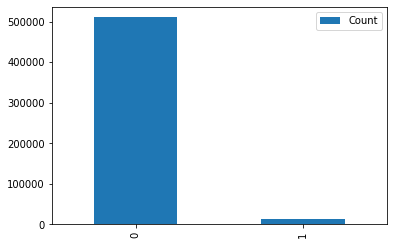

time: 1.28 s


In [30]:
client \
  .query("select count(1) as Count from `ieee_cis_fraud_detection.train_enriched_cleaned_up` group by isFraud") \
  .to_dataframe().plot(kind='bar')

# Model machine learning

In [11]:
%%bigquery

CREATE OR REPLACE MODEL `ieee_cis_fraud_detection.fraud_detection`
OPTIONS(
    model_type='logistic_reg', 
    input_label_cols=['isFraud'],
    AUTO_CLASS_WEIGHTS=TRUE,
    L1_REG=0.3
) AS
select * EXCEPT (x) FROM (
(SELECT RAND() as x, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 0 ORDER BY X LIMIT 30000)
UNION ALL SELECT RAND() as X, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 1
UNION ALL SELECT RAND() as X, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 1
) ORDER BY TransactionDT ASC

""


time: 3min 19s


# Bilansowanie zbioru danych

In [ ]:
%%bigquery
select count(1) FROM (
(SELECT RAND() as x, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 0 ORDER BY X LIMIT 30000)
UNION ALL SELECT RAND() as X, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 1
UNION ALL SELECT RAND() as X, * EXCEPT(TransactionID) FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 1
) group by isfraud

# Jak dobry jest nasz model?

In [31]:
%%bigquery
SELECT * FROM ML.EVALUATE(MODEL `ieee_cis_fraud_detection.fraud_detection`)

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.763941,0.805181,0.795382,0.784019,0.454942,0.877865


time: 1.65 s


# What-if Tool

In [14]:
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

time: 4.21 s


In [32]:
%%bigquery what_if_examples
SELECT * EXCEPT(x) FROM (
(SELECT RAND() as x, * FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 0 ORDER BY x LIMIT 500)
UNION ALL
(SELECT RAND() as x, * FROM `ieee_cis_fraud_detection.train_enriched_cleaned_up` WHERE isFraud = 1 ORDER BY x LIMIT 500))

time: 11.7 s


In [33]:
config_builder = WitConfigBuilder(df_to_examples(what_if_examples)).set_target_feature('isFraud').set_custom_predict_fn(cfun).set_model_type('classification')

time: 14.6 s


In [34]:
WitWidget(config_builder, height=800) 

WitWidget(config={'model_type': 'classification', 'label_vocab': [], 'are_sequence_examples': False, 'target_f…

time: 9.77 s
